In [1]:
# Windows: first, install Visual Studio build tools
# pip install nes-py
# pip install gym-super-mario-bros

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

Gameboy has 12 buttons, each can be either on or off at each moment of time (sounds familiar...). It is not a good idea to have 2^12 actions in action space, so there are some sets of buttons combinations. COMPLEX_MOVEMENT is considered as the hardest one although it has only 12 combinations.

So, the cardinality of our action space will be 12.

In [2]:
from LRL import *

Reward is measured in hundreds, while good combinations of hyperparameters for RL algorithms are found for games with reward near zero. So, it seemed benefitial to scale reward by dividing it on 100.

In [3]:
class ScaleRewardEnv(gym.RewardWrapper):
    def reward(self, reward):
        return reward / 100

One more simplification: if we die, game ends. No three lifes when Mario can touch enemy, die and respawn at the beginning of the level without "done" flag for experience replay. I restart the whole game at such moments, so: we always start at the beginning of level 1, all bonuses are restored, we have 1 life.

In [4]:
class EpisodicLifeMarioEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        
        self.was_real_done = done
        if info["life"] < self.lives:
            done = True
        self.lives = info["life"]
        
        return obs, reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

Final magic is taken from original article on curiosity. They make picture greyscale (it is common), but use special coeffecients for channels. In their code there is a comment (!) that this is critical. Well, ok...

In [5]:
class RGB2Y(gym.Wrapper):
    def __init__(self, env=None):
        super().__init__(env)
        self.observation_space = gym.spaces.box.Box(0.0, 255.0, (*env.observation_space.shape[:-1], 1))
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        
        return self._rgb2y(obs), reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        return self._rgb2y(obs)

    def _rgb2y(self, im):
        """Converts an RGB image to a Y image (as in YUV).
        These coefficients are taken from the torch/image library.
        Beware: these are more critical than you might think, as the
        monochromatic contrast can be surprisingly low. TAKEN FROM PAPER
        """
        return np.sum(im * np.array([0.299, 0.587, 0.114]), axis=2)[:,:,None]

Full environment preprocessing.

In [6]:
def create_env():
    def _thunk():
        env = gym_super_mario_bros.make('SuperMarioBros-v0')
        env = JoypadSpace(env, COMPLEX_MOVEMENT)             # we want 12 actions instead of 2^12
        env = ScaleRewardEnv(env)                            # mine: scale reward by dividing on 100
        env = EpisodicLifeMarioEnv(env)                      # mine: done when die
                                                             # make picture 42 x 42. YEP this is taken from Curiosity article!
        env = atari_wrappers.WarpFrame(env, width=42, height=42, grayscale=False)
        env = RGB2Y(env)                                     # greyscale magic from original article
        env = atari_wrappers.MaxAndSkipEnv(env, skip=4)      # atari: take 4 frames and apply max-pool.
        env = atari_wrappers.FrameStack(env, k=4)            # original article: stack last 4 frames
        env = atari_wrappers.ScaledFloatFrame(env)           # divide on 255 and turn into float
        env = atari_wrappers.ImageToPyTorch(env)             # pytorch wants channels x W x H
        return env
    return _thunk

In [7]:
env = create_env()()
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(4, 42, 42)
Action space: Discrete(12)


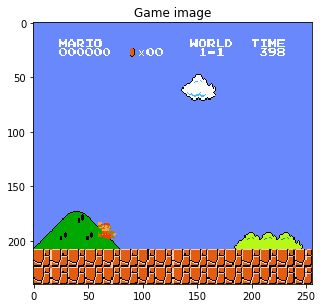

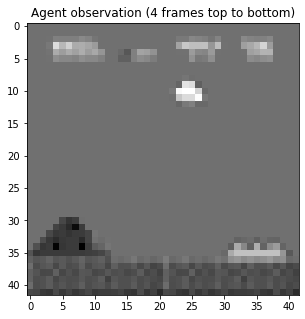

In [8]:
env.reset()
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[5,5])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[5,5])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs[-1].T, cmap='gray')
plt.show()

Network architecture is taken from curiosity article (nothing fancy).

In [9]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

class MarioNN(nn.Module):
    def __init__(self, linear):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),           
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            Flatten(),
            nn.Linear(288, 256),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x).reshape(x.shape[0], -1)

Experiments with inverse model and Rainbow failed...

In [10]:
# class InverseModelNetwork(InverseModelHead):
#     def __init__(self, config, name):
#         super().__init__(config, name)

#         self.head = nn.Sequential(
#             self.linear(self.feature_size * 2, 300),
#             nn.ReLU(),
#             self.linear(300, config.num_actions)
#         )

#     def forward(self, state, next_state):
#         f1 = self.feature_extractor_net(state)
#         f2 = self.feature_extractor_net(next_state)
#         return self.head(torch.cat([f1, f2], dim=1))

In [11]:
# config = {
#     "env": env,
#     "Qnetwork_FeatureExtractor": MarioNN,
#     "QnetworkHead": DuelingQuantileQnetwork,    
#     "Qnetwork_optimizer_args": {"lr": 0.0001},
#     "Qnetwork_linear": NoisyLinear(std_init=0.4),
#     "batch_size": 32,
#     "gamma": 0.999,
#     "target_update": 1000,
#     "replay_buffer_nsteps": 5,
#     "replay_buffer_init": 128,
#     "replay_buffer_capacity": 100000,
#     "rp_alpha": 0.6, "rp_beta_start": 0.4, "rp_beta_frames": 100000,
#     "clip_priorities": 1000,
#     "quantiles": 51,
#     "InverseModelHead": InverseModelNetwork,
#     "InverseModel_FeatureExtractor": MarioNN,
#     "InverseModel_optimizer_args": {"lr": 0.001},
#     "curiosity_coeff": 0.01
# }

In [12]:
# agent = DoubleQAgent(QuantileQAgent(NstepReplay(InverseModel(PrioritizedBufferAgent))))(config)

PPO rules.

In [13]:
config = {
    "make_env": create_env,
    "threads": 8,
    "ActorCritic_FeatureExtractor": MarioNN,
    "ActorCriticHead": ActorCritic,
    "ActorCritic_optimizer": optim.Adam,
    "ActorCritic_optimizer_args": {"lr": 0.00001},
    "ActorCritic_clip_gradients": 1,
    "rollout": 128,
    "ppo_clip": 0.1, 
    "epochs": 3, 
    "batch_size": 32,
    "gamma": 0.999,
    "gae_tau": 0.95,
    "critic_loss_weight": 0.5,
    "entropy_loss_weight": 0.01,
    #"replay_buffer_capacity": 100000,
    #"InverseModelHead": InverseModelNetwork,
    #"InverseModel_FeatureExtractor": MarioNN,
    #"InverseModel_optimizer_args": {"lr": 0.01},
    #"curiosity_coeff": 0.01
}

In [14]:
agent = GAE(PPO(A2C(Agent)))(config)

In [15]:
# loading model
agent.load("models/mario_ppo")

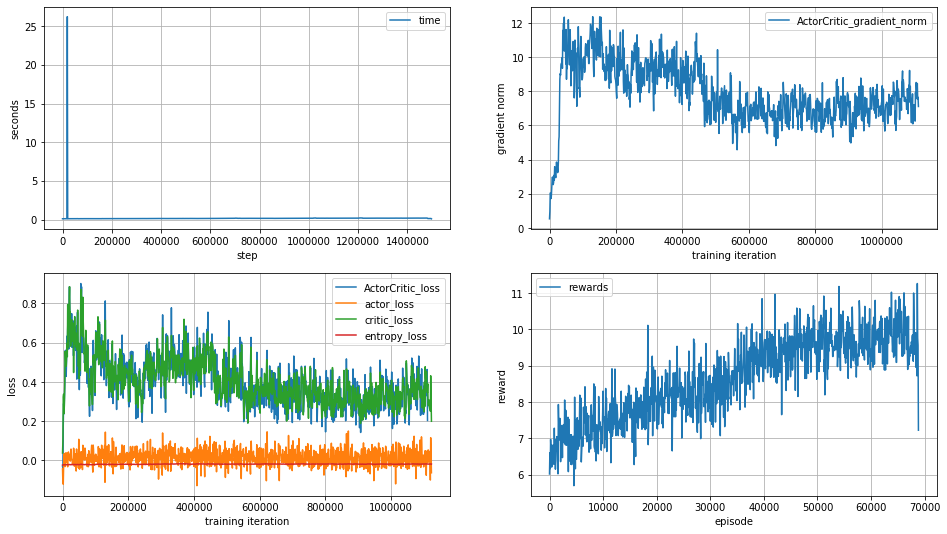

In [22]:
plot_durations(agent)

In [ ]:
agent.learn(10000000)

I have some problems with showing games inside notebook after matplotlib 3.0

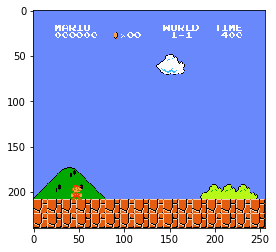

NameError: name 'show_frames_and_distribution' is not defined

In [21]:
agent.play(render=True, record=True)

So I just store the game to video file.

In [140]:
import imageio
imageio.mimwrite('ppo-longtrain.mp4', agent.record["frames"])

Saving model

In [141]:
agent.save("models/mario_ppo")

# Learning statistics

Learning time in minutes:

In [30]:
(sum(agent.logger['time']) - max(agent.logger['time'])) / 60

3640.1502142111462

In [33]:
len(agent.logger['rewards'])

68877

Text(0.5, 1.0, 'REWARDS')

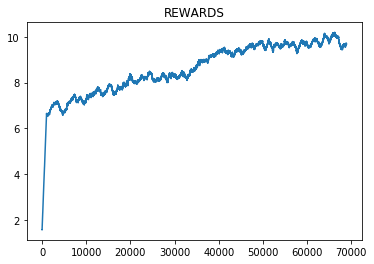

In [37]:
plt.plot(sliding_average(agent.logger['rewards'], 1000))
plt.title("REWARDS")

# Стэк экспериментов

**07/10/19**
1. Бэйслайн (10000 шагов). Не умер, но стоит на месте. Куриосити даёт > +1/сек
2. Смена гаммы на 0.999, MaxSkip 4 кадра. Таргет-апдейт 250 шагов вместо 100, epsilon_decay поднял до 10000. Набрал дважды честно 2000 награды. Тупит. Куриосити даёт >+1/сек
3. Добавил линейный слой в голову обратной модели. Поставил на ночь. Взрыв Q-фнкции. Реплей буффер сожрал 32 гига памяти.

**08/10/19**
4. Убрал inverse model и тренирую обычную DQN. Реплей буффер сделал в 10 раз меньше. Кажется, тоже будет взрыв, обучается долго. Тупит.
5. Посмотрим на QR-Rainbow. Лосс едет вверх, тупит. И почему медиана весов приоритизированного реплея 1?
6. target-update увеличен до 1000. После 25000 шагов: чёт делает, лосс вырос до 600. Медиана весов всё ещё 1. После 100000: всё также, лосс растёт. Медиана такая, потому что clip_priorities=1, лол
7. clip_priorities=1000. Лосс всё ещё растёт, но медленнее. Тупит.
8. Миллион параметров это не очень... Добавил ещё свёртку и сократил feature_size фиче-экстрактора до 64. Количество параметров упало в 1000 раз. Лосс радостно упал на порядок... а нет, снова растёт, результаты те же, и всё ещё страшно тупит
9. Количество фичей в свёртках поднял до 32. Лосс растёт чуть медленнее.
10. learning_rate выставил в 0.0001. Кажись, дела совсем плохи...

**09/10/09**
11. nsteps = 3 -> 5. Вообще научился за день тупо вправо идти.

**10/10/09**
12. Запустим-ка PPO... Критик взрывается - поставим вес 0.01. Полный облом - схлопывается.
13. learning rate = 1e-5. Тоже самое.

**11/10/09**
14. Уменьшим-ка ревард в сто раз. Вернём критику вес 1. Не схлопывается, но за тысячу игр ревард растёт так себе. Однако, учится, лол. Да, учится, но медленно.

**12/10/09**
15. Уменьшаем ревард ещё в 10 раз. GAE tau меняем на 0.98... Чуть-чуть вперёд идёт, но страшно тупит.
16. Вернём ревард (в сто раз меньше дефолтного)... Проверяем, сломало ли нам всё GAE... За ночь так и не научился перепрыгивать яму.

**13/10/09**
17. Лосс критика уменьшаем в 10 раз. Чёт всё также...
18. Увеличим-ка lr обратно в 1e-4... Всё также
19. Вернём GAE tau в 0.95. Включим обрезку градиентов 0.5... Посмотрим, что будет... проваливается в яму, короче

**19/10/19**
Попробуем-ка ещё раз. Ревард уменьшен в сто раз, изображение сжато до 84х84 и застэкано  4 предыдущими моментами времени. Фич на выходе свёрточной всего 288. Мысль: а там, походу, при потери жизни done не бросается, это плохо.
20. Попробуем-ка запустить qr-радугу ещё раз на ревардах, уменьшенных в сто раз, может ему полегче будет. Учится идти вправо и тупить.
21. Включаем episodic life. ЖДЁМ-С, лосс падает, ревард тоже.
22. Нормализуем изображение. Пришлось повысить std_init в NoisyLinear, ну ё моё. Поставил на ночь. Схлопнулось, вылезло, но всё ещё бежит вправо и врезается в первого же врага. Это из-за шума что ли?

**22/10/19**
23. Ничего не понятно. Убрал нормализацию изображения. Добавил Inverse Model, поставил коэф. 0.01, чтобы награда по масштабу соответствовала внешней мотивации. Лосс растёт, награда скачет. Это из-за шумных сетей что ли? Бежит вправо и тыкается в первого врага.

**23/10/19**
24. Поставил PPO без любопытства на подольше. Ревард-то в среднем (!) растёт. Продолжает расти несколько дней, потом выходит на асимптоту. Итого: часто доходит до второй ямы, но не дальше.